# Montu Python 
## Astronomical ephemerides for the Ancient World
## Example: Venus Azimutal Distributions


### Goals of this notebook

The goal of this notebook is to compute the distribution of Venus azimuths at dawn. 

In [1]:
# Uncomment this line in Colab
# !pip install -q montu

### Loading tools

We need to load the packages and the required data for it (star database, planet position database, etc.):

In [1]:
# Montu packages and data
import montu
from montu import D2H, PRINTDF, TABLEDF, DEG, RAD

# Other libraries required
import pandas as pd
import copy
import matplotlib.pyplot as plt
import numpy as np

# Load allstars
allstars = montu.Stars()

# These magic commands are intended to allow updating the packages if they change
%load_ext autoreload
%autoreload 2

Running MontuPython version 0.9.1


### Venus appearances

Lets set observing conditions and initial time of exploration:

In [2]:
Tebas = montu.Observer(lon=33,lat=24,height=0)

Our target body:

In [3]:
venus = montu.Planet('Venus')
sun = montu.Sun()

Now let's compute the conditions of observation of Venus for a given date:

In [4]:
mtime = montu.Time('-2500-12-04 12:00:00')
#mtime = montu.Time()
print(f"Conditions for Venus observations at {mtime.readable.datemix}")
print('='*80)

# Compute Venus condition
venus.conditions_in_sky(at=mtime,observer=Tebas)

# Compute Sun conditions
sun.conditions_in_sky(at=mtime,observer=Tebas)
print("Sun rise time:",Tebas.get_local_time(sun.condition.rise_time))
print("Sun set time:",Tebas.get_local_time(sun.condition.set_time))
print()

dusk_time,dawn_time = montu.Sun.when_is_twilight(day=mtime,observer=Tebas,sunbelow=-18)
print("Time when dawn twilight ends: ",Tebas.get_local_time(dawn_time))
print("Time when dusk twilight starts: ",Tebas.get_local_time(dusk_time))
print()

print("Venus rise time:",Tebas.get_local_time(venus.condition.rise_time))
print("Venus set time:",Tebas.get_local_time(venus.condition.set_time))
print()

# Determine if it will be visible at dawn or dusk
mtime_obs = None
print("Visibility conditions:")
if venus.condition.set_time > sun.condition.set_time:
    print("\tVisible at dawn")
    
    # Determine if it will be visible when twilight has ended
    if venus.condition.set_time > dawn_time:
        print("\t\tVisible after dawn twilight ends")
        mtime_obs = montu.Time(dawn_time,format='jd')
        state = 'dawn'

elif venus.condition.rise_time < sun.condition.rise_time:
    print("\tVisible at dusk")

    # Determine if it will be visible when twilight has ended
    if venus.condition.rise_time < dusk_time:
        print("\t\tVisible before dusk twilight start")
        mtime_obs = montu.Time(dusk_time,format='jd')
        state = 'dusk'
else:
    print("Venus is transiting the Sun")

print()
if mtime_obs:
    venus.conditions_in_sky(at=mtime_obs,observer=Tebas)
    print(f"Venus position at {state}:")
    print(f"\tAz,el: {D2H(venus.position.az)}, {D2H(venus.position.el)}")
    print(f"\tMagnitude: {venus.condition.Vmag}")


Conditions for Venus observations at -2500-12-24 12:00:00
Sun rise time: 06:43:15.991
Sun set time: 17:21:36.721

Time when dawn twilight ends:  18:43:38.682
Time when dusk twilight starts:  05:21:14.773

Venus rise time: 03:49:59.347
Venus set time: 15:20:35.530

Visibility conditions:
	Visible at dusk
		Visible before dusk twilight start

Venus position at dusk:
	Az,el: 110:09:3.011, 19:38:22.416
	Magnitude: -4.43


Let's do it for many dates during a whole Synodic period:

In [168]:
mtime_initial = montu.Time('-2500-12-04 12:00:00')

venus_conditions = []
for dt in montu.PROGRESS(
    montu.Util.arange(0,10*montu.ALLPLANETS.loc['Venus','SynodicOrbit']*montu.YEAR,1*montu.DAY)
    ):
    
    mtime = mtime_initial + dt

    # Compute Sun conditions
    sun.conditions_in_sky(at=mtime,observer=Tebas)
    dusk_time,dawn_time = montu.Sun.when_is_twilight(day=mtime,observer=Tebas,sunbelow=-18)

    # Compute Venus condition
    venus.conditions_in_sky(at=mtime,observer=Tebas)

    # Conditions
    visible_at_dawn = False
    visible_at_dusk = False
    visible_before_dusk = False
    visible_after_dawn = False

    # Determine if it will be visible at dawn or dusk
    mtime_obs = None
    az_horizon = 361
    if venus.condition.set_time > sun.condition.set_time:
        visible_at_dawn = True
        az_horizon = venus.condition.set_az    
        # Determine if it will be visible when twilight has ended
        if venus.condition.set_time > dawn_time:
            visible_after_dawn = True
            mtime_obs = montu.Time(dawn_time,format='jd')
            state = 'dawn'

    elif venus.condition.rise_time < sun.condition.rise_time:
        visible_at_dusk = True
        az_horizon = venus.condition.rise_az
        # Determine if it will be visible when twilight has ended
        if venus.condition.rise_time < dusk_time:
            visible_before_dusk = True
            mtime_obs = montu.Time(dusk_time,format='jd')
            state = 'dusk'
    else:
        pass

    az_twilight = None
    el_twilight = None
    if mtime_obs:
        venus.conditions_in_sky(at=mtime_obs,observer=Tebas)
        az_twilight = venus.position.az
        el_twilight = venus.position.el

    venus_conditions += [dict(
        jed = mtime.jed,
        sun_rise_time = sun.condition.rise_time,
        sun_set_time = sun.condition.set_time,
        dusk_time = dusk_time,
        dawn_time = dawn_time,
        venus_rise_time = venus.condition.rise_time,
        venus_set_time = venus.condition.set_time,
        visible_at_down = visible_at_dawn,
        visible_after_dawn = visible_after_dawn,
        visible_at_dusk = visible_at_dusk,
        visible_before_dusk = visible_before_dusk,
        az_horizon = az_horizon,
        az_twilight = az_twilight,
        el_twilight = el_twilight,
    )]

mtime_final = mtime.get_readable()
venus_conditions = pd.DataFrame(venus_conditions)
venus_conditions

  0%|          | 0/5840 [00:00<?, ?it/s]

100%|██████████| 5840/5840 [00:30<00:00, 190.66it/s]


,jed,sun_rise_time,sun_set_time,dusk_time,dawn_time,venus_rise_time,venus_set_time,visible_at_down,visible_after_dawn,visible_at_dusk,visible_before_dusk,az_horizon,az_twilight,el_twilight
0,808291.000000,808290.688380,808291.131675,808290.631421,808291.188642,808290.568048,808291.047633,False,False,True,True,99.829813,110.150836,19.639560
1,808292.000000,808291.688848,808292.131799,808291.631839,808292.188816,808291.566593,808292.045876,False,False,True,True,99.972297,110.654201,20.200522
2,808293.000000,808292.689309,808293.131937,808292.632252,808293.189002,808292.565226,808293.044172,False,False,True,True,100.129658,111.160373,20.729006
3,808294.000000,808293.689763,808294.132089,808293.632661,808294.189198,808293.563944,808294.042519,False,False,True,True,100.301075,111.668682,21.225965
4,808295.000000,808294.690208,808295.132255,808294.633064,808295.189406,808294.562745,808295.040916,False,False,True,True,100.485777,112.178426,21.692259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5835,814126.005111,814125.683940,814126.131214,814125.627547,814126.187618,814125.573122,814126.056935,False,False,True,True,97.944510,106.550104,17.008821
5836,814127.005111,814126.684449,814127.131200,814126.627984,814127.187676,814126.571272,814127.054976,False,False,True,True,98.004793,107.016688,17.721932
5837,814128.005111,814127.684956,814128.131202,814127.628420,814128.187748,814127.569524,814128.053074,False,False,True,True,98.084406,107.490157,18.399249
5838,814129.005111,814128.685458,814129.131219,814128.628855,814129.187833,814128.567876,814129.051228,False,False,True,True,98.182535,107.969937,19.041669


Exclude problematic conditions:

In [170]:
cond = (venus_conditions.az_twilight == 361)|(venus_conditions.az_horizon == 361)
venus_conditions = venus_conditions[~cond]

Plot conditions:

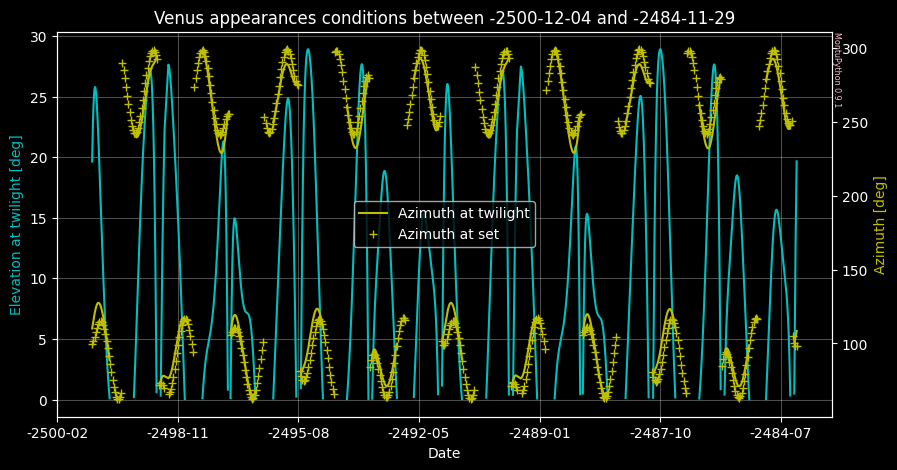

In [197]:
with plt.style.context('dark_background'):
    fig,ax_el = plt.subplots(figsize=(10,5))
    ax_az = ax_el.twinx()
    
    ax_el.plot(venus_conditions.jed,venus_conditions.el_twilight,'c')
    
    ax_az.plot(venus_conditions.jed,venus_conditions.az_twilight,'y',label='Azimuth at twilight')
    ax_az.plot(venus_conditions.jed[::10],venus_conditions.az_horizon[::10],'y+',label='Azimuth at set')

    # Decorate
    montu.Time.set_time_ticks(ax_el,format='jd',timefmt='%Y-%m',fontsize=10)
    ax_el.set_xlabel('Date')
    ax_el.set_ylabel('Elevation at twilight [deg]',color='c')
    ax_az.set_ylabel('Azimuth [deg]',color='y')
    ax_az.legend(loc='center')

    ax_el.set_title(f"Venus appearances conditions between {mtime_initial.strftime('%Y-%m-%d')} and {mtime_final.strftime('%Y-%m-%d')}")
    ax_el.grid(alpha=0.3)
    montu.Util.montu_mark(ax_el);
    fig.savefig('montmp/venus-appearances.png')

Histogram of azimuths:

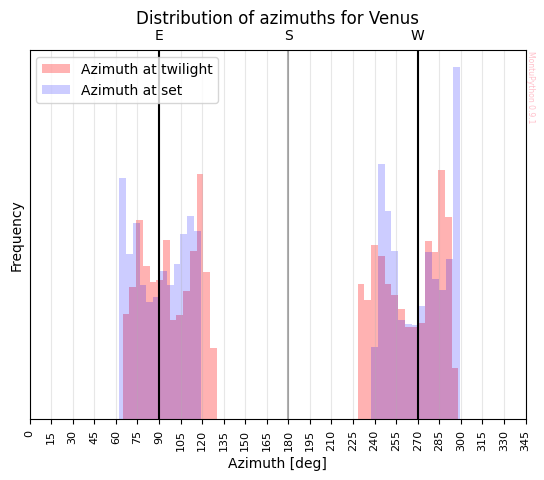

In [198]:
fig,ax = plt.subplots()

hs,xs,bs = ax.hist(
    venus_conditions.az_twilight,
    bins=50,density=True,
    color='r',alpha=0.3,
    label = 'Azimuth at twilight'
    )

hs,xs,bs = ax.hist(
    venus_conditions.az_horizon,
    bins=50,density=True,
    color='b',alpha=0.2,
    label = 'Azimuth at set'
    )

hmax = hs.max()
# vertical bars
ax.axvline(90,color='k')
ax.text(90,1.08*hmax,'E',ha='center')
ax.axvline(180,color='k',alpha=0.3)
ax.text(180,1.08*hmax,'S',ha='center')
ax.axvline(270,color='k')
ax.text(270,1.08*hmax,'W',ha='center')

ax.set_xticks(np.arange(0,360,15))
ax.tick_params(axis='x',which='major',labelsize=8,rotation=90)
ax.set_yticks([])

ax.legend()
ax.grid(alpha=0.3)
ax.set_xlabel('Azimuth [deg]')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of azimuths for Venus',x=0.5,y=1.05)

montu.Util.montu_mark(ax);
fig.savefig('montmp/venus-appearances-distribution.png')

## The same but for Jupiter

In [203]:
jupiter = montu.Planet('Jupiter')

mtime_initial = montu.Time('-2500-12-04 12:00:00')

jupiter_conditions = []
for dt in montu.PROGRESS(
    montu.Util.arange(0,10*montu.ALLPLANETS.loc['Jupiter','SynodicOrbit']*montu.YEAR,30*montu.DAY)
    ):
    
    mtime = mtime_initial + dt

    # Compute Sun conditions
    sun.conditions_in_sky(at=mtime,observer=Tebas)
    dusk_time,dawn_time = montu.Sun.when_is_twilight(day=mtime,observer=Tebas,sunbelow=-18)

    # Compute jupiter condition
    jupiter.conditions_in_sky(at=mtime,observer=Tebas)

    # Conditions
    visible_at_dawn = False
    visible_at_dusk = False
    visible_before_dusk = False
    visible_after_dawn = False

    # Determine if it will be visible at dawn or dusk
    mtime_obs = None
    az_horizon = 361
    if jupiter.condition.set_time > sun.condition.set_time:
        visible_at_dawn = True
        az_horizon = jupiter.condition.set_az    
        # Determine if it will be visible when twilight has ended
        if jupiter.condition.set_time > dawn_time:
            visible_after_dawn = True
            mtime_obs = montu.Time(dawn_time,format='jd')
            state = 'dawn'

    elif jupiter.condition.rise_time < sun.condition.rise_time:
        visible_at_dusk = True
        az_horizon = jupiter.condition.rise_az
        # Determine if it will be visible when twilight has ended
        if jupiter.condition.rise_time < dusk_time:
            visible_before_dusk = True
            mtime_obs = montu.Time(dusk_time,format='jd')
            state = 'dusk'
    else:
        pass

    az_twilight = None
    el_twilight = None
    if mtime_obs:
        jupiter.conditions_in_sky(at=mtime_obs,observer=Tebas)
        az_twilight = jupiter.position.az
        el_twilight = jupiter.position.el

    jupiter_conditions += [dict(
        jed = mtime.jed,
        sun_rise_time = sun.condition.rise_time,
        sun_set_time = sun.condition.set_time,
        dusk_time = dusk_time,
        dawn_time = dawn_time,
        jupiter_rise_time = jupiter.condition.rise_time,
        jupiter_set_time = jupiter.condition.set_time,
        visible_at_down = visible_at_dawn,
        visible_after_dawn = visible_after_dawn,
        visible_at_dusk = visible_at_dusk,
        visible_before_dusk = visible_before_dusk,
        az_horizon = az_horizon,
        az_twilight = az_twilight,
        el_twilight = el_twilight,
    )]

mtime_final = mtime.get_readable()
jupiter_conditions = pd.DataFrame(jupiter_conditions)

cond = (jupiter_conditions.az_twilight == 361)|(jupiter_conditions.az_horizon == 361)
jupiter_conditions = jupiter_conditions[~cond]

  7%|▋         | 9/133 [00:00<00:01, 74.59it/s]

100%|██████████| 133/133 [00:01<00:00, 70.16it/s]


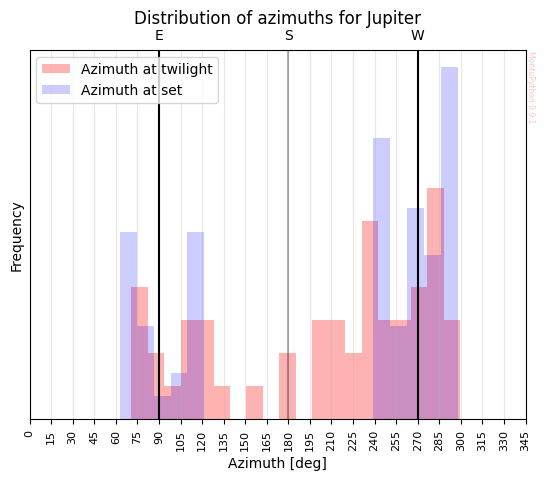

In [205]:
fig,ax = plt.subplots()

hs,xs,bs = ax.hist(
    jupiter_conditions.az_twilight,
    bins=20,density=True,
    color='r',alpha=0.3,
    label = 'Azimuth at twilight'
    )

hs,xs,bs = ax.hist(
    jupiter_conditions.az_horizon,
    bins=20,density=True,
    color='b',alpha=0.2,
    label = 'Azimuth at set'
    )

hmax = hs.max()
# vertical bars
ax.axvline(90,color='k')
ax.text(90,1.08*hmax,'E',ha='center')
ax.axvline(180,color='k',alpha=0.3)
ax.text(180,1.08*hmax,'S',ha='center')
ax.axvline(270,color='k')
ax.text(270,1.08*hmax,'W',ha='center')

ax.set_xticks(np.arange(0,360,15))
ax.tick_params(axis='x',which='major',labelsize=8,rotation=90)
ax.set_yticks([])

ax.legend()
ax.grid(alpha=0.3)
ax.set_xlabel('Azimuth [deg]')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of azimuths for Jupiter',x=0.5,y=1.05)

montu.Util.montu_mark(ax);
fig.savefig('montmp/jupiter-appearances-distribution.png')

## Mercury

In [207]:
mercury = montu.Planet('mercury')

mtime_initial = montu.Time('-2500-12-04 12:00:00')

mercury_conditions = []
for dt in montu.PROGRESS(
    montu.Util.arange(0,10*montu.ALLPLANETS.loc['Mercury','SynodicOrbit']*montu.YEAR,1*montu.DAY)
    ):
    
    mtime = mtime_initial + dt

    # Compute Sun conditions
    sun.conditions_in_sky(at=mtime,observer=Tebas)
    dusk_time,dawn_time = montu.Sun.when_is_twilight(day=mtime,observer=Tebas,sunbelow=-18)

    # Compute mercury condition
    mercury.conditions_in_sky(at=mtime,observer=Tebas)

    # Conditions
    visible_at_dawn = False
    visible_at_dusk = False
    visible_before_dusk = False
    visible_after_dawn = False

    # Determine if it will be visible at dawn or dusk
    mtime_obs = None
    az_horizon = 361
    if mercury.condition.set_time > sun.condition.set_time:
        visible_at_dawn = True
        az_horizon = mercury.condition.set_az    
        # Determine if it will be visible when twilight has ended
        if mercury.condition.set_time > dawn_time:
            visible_after_dawn = True
            mtime_obs = montu.Time(dawn_time,format='jd')
            state = 'dawn'

    elif mercury.condition.rise_time < sun.condition.rise_time:
        visible_at_dusk = True
        az_horizon = mercury.condition.rise_az
        # Determine if it will be visible when twilight has ended
        if mercury.condition.rise_time < dusk_time:
            visible_before_dusk = True
            mtime_obs = montu.Time(dusk_time,format='jd')
            state = 'dusk'
    else:
        pass

    az_twilight = None
    el_twilight = None
    if mtime_obs:
        mercury.conditions_in_sky(at=mtime_obs,observer=Tebas)
        az_twilight = mercury.position.az
        el_twilight = mercury.position.el

    mercury_conditions += [dict(
        jed = mtime.jed,
        sun_rise_time = sun.condition.rise_time,
        sun_set_time = sun.condition.set_time,
        dusk_time = dusk_time,
        dawn_time = dawn_time,
        mercury_rise_time = mercury.condition.rise_time,
        mercury_set_time = mercury.condition.set_time,
        visible_at_down = visible_at_dawn,
        visible_after_dawn = visible_after_dawn,
        visible_at_dusk = visible_at_dusk,
        visible_before_dusk = visible_before_dusk,
        az_horizon = az_horizon,
        az_twilight = az_twilight,
        el_twilight = el_twilight,
    )]

mtime_final = mtime.get_readable()
mercury_conditions = pd.DataFrame(mercury_conditions)

cond = (mercury_conditions.az_twilight == 361)|(mercury_conditions.az_horizon == 361)
mercury_conditions = mercury_conditions[~cond]

  0%|          | 0/1159 [00:00<?, ?it/s]

100%|██████████| 1159/1159 [00:07<00:00, 159.60it/s]


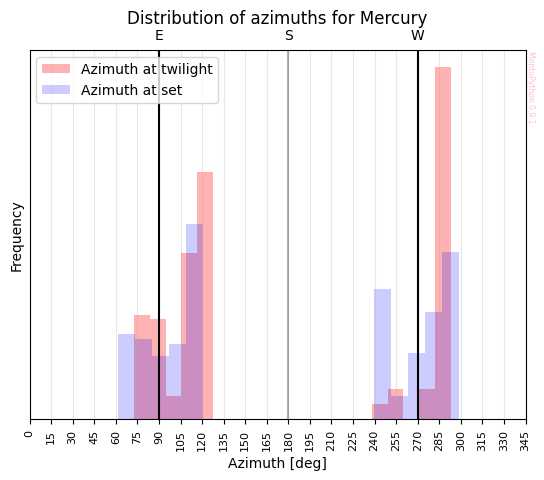

In [209]:
fig,ax = plt.subplots()

hs1,xs,bs = ax.hist(
    mercury_conditions.az_twilight,
    bins=20,density=True,
    color='r',alpha=0.3,
    label = 'Azimuth at twilight'
    )

hs2,xs,bs = ax.hist(
    mercury_conditions.az_horizon,
    bins=20,density=True,
    color='b',alpha=0.2,
    label = 'Azimuth at set'
    )

hmax = max(hs1.max(),hs2.max())
# vertical bars
ax.axvline(90,color='k')
ax.text(90,1.08*hmax,'E',ha='center')
ax.axvline(180,color='k',alpha=0.3)
ax.text(180,1.08*hmax,'S',ha='center')
ax.axvline(270,color='k')
ax.text(270,1.08*hmax,'W',ha='center')

ax.set_xticks(np.arange(0,360,15))
ax.tick_params(axis='x',which='major',labelsize=8,rotation=90)
ax.set_yticks([])

ax.legend()
ax.grid(alpha=0.3)
ax.set_xlabel('Azimuth [deg]')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of azimuths for Mercury',x=0.5,y=1.05)

montu.Util.montu_mark(ax);
fig.savefig('montmp/mercury-appearances-distribution.png')

The end!